#### Implementing simple chatbot and practicing streaming

In [1]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class stateclass(TypedDict):
    """State class for the graph."""
    messages: Annotated[list, add_messages]
    

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [4]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BpDX9BWMMHB3FfgD1IwLapfcN7gBM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e197dd24-8cbf-4f9e-99a6-d5b9c32a4ff7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langchain_groq import ChatGroq

llm_groq=ChatGroq(model="qwen-qwq-32b")
llm_groq.invoke("Hey I am Abubakar and i like to play cricket")

AIMessage(content="\n<think>\nOkay, the user is Abubakar and he mentioned he likes to play cricket. I should start by greeting him and acknowledging his interest in cricket. Maybe ask him about his role in the game—like does he prefer batting or bowling? Also, cricket has different formats, so I can ask if he prefers Test matches, T20s, or ODIs. Including a question about favorite teams or players could keep the conversation going. I need to make sure the tone is friendly and encouraging to keep the interaction engaging. Let me put that together in a natural way without making it sound like a list of questions. Maybe add a comment about cricket being a great sport to bring people together. Alright, let's draft the response.\n</think>\n\nHello Abubakar! That's awesome—cricket is such a thrilling sport. Do you prefer batting or bowling more? Also, what's your favorite format to play or watch: Test matches, ODI, or T20? And if you don’t mind me asking, who’s your favorite cricketer or tea

In [6]:
### Defining Memory

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [7]:
def my_bot(state: stateclass):
    return {"messages":[llm_groq.invoke(state["messages"])]}

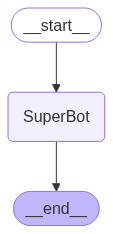

In [8]:
graph=StateGraph(stateclass)

## node
graph.add_node("SuperBot",my_bot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [10]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Abubakar And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='6d9ac736-cdf2-4497-a383-5d5f769e756e'),
  AIMessage(content="\n<think>\nOkay, the user introduced himself as Krish and mentioned he likes cricket. I should respond in a friendly way to acknowledge his introduction. Let me start by welcoming him and expressing that it's nice to meet him. Then, since he mentioned cricket, I can ask him more about it. Maybe find out what aspects of cricket he enjoys—playing, watching, following a team, or a favorite player. That should encourage a conversation. I should keep the tone positive and approachable. Let me check if there's anything else to consider, like any specific terms or nuances in cricket he might be interested in. But since he just mentioned liking cricket, keeping it general is better. Alright, putting it all together now.\n</think>\n\nHello Krish! Nice to meet you. That's a great interest—cricket is such a thrill

### Streaming
#### Streaming the response with stream method

In [12]:
### Creating thread and using stream method UPDATE

config = {"configurable": {"thread_id": "101"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Abubakar And I like cricket"},config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="\n<think>\nOkay, the user is Abubakar, and he mentioned he likes cricket. I should respond warmly and show interest in his favorite sport. Let me start by greeting him again and then ask about his favorite team or players. Maybe I can mention a popular team or player to spark a conversation. I should keep it friendly and open-ended to encourage him to share more. Let me also check if there's any specific event or match he's excited about. Keeping the tone positive and enthusiastic will make the interaction better. Alright, time to put that into a message.\n</think>\n\nHello again, Abubakar! It's great to see you again and talk more about cricket. What's your favorite part of the game? Is it the thrill of a boundary hit, the strategy of captaincy, or maybe the excitement of a close chase? I’d love to hear more about what makes cricket special for you! 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 187, 'pro

In [13]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Abubakar And I like cricket', additional_kwargs={}, response_metadata={}, id='10ba579c-af96-4dca-97e1-fcdb12b818ce'), AIMessage(content="\n<think>\nOkay, the user introduced himself as Abubakar and mentioned he likes cricket. I should respond warmly. Let me start by greeting him back. Maybe ask how he's doing today. Then, since he mentioned cricket, I can express that I'm also a fan and ask if he follows any particular team or players. I should keep it friendly and open-ended to encourage conversation. Let me check for any typos and make sure the tone is positive. Alright, that should work.\n</think>\n\nHello Abubakar! Nice to meet you. I hope you're having a great day! 😊 Cricket is an amazing sport—do you follow any particular team or players? I’m a big fan too, so feel free to share anything you love about the game!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 23, 'total_tokens'

In [14]:
for chunk in graph_builder.stream({'messages':"I also like football "},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='\n<think>\nOkay, the user mentioned they like both cricket and football. Let me start by acknowledging that. They might be looking for a friendly conversation about sports. Since they repeated "I also like football," maybe they want to talk more about football now.\n\nI should ask about their favorite teams or players in football to keep the conversation going. Maybe they support a specific country or club. Also, I should keep the tone enthusiastic and open-ended. Let them know I\'m interested in their preferences. Need to make sure my response is engaging and invites them to share more details. Let me check the previous messages to see if they mentioned anything else that can be connected. They didn\'t, so focus on football now. Maybe mention different aspects like leagues, World Cups, or specific players to prompt their interests.\n</think>\n\nThat’s a fantastic combination! Both cricket and football have so much excitement. Do you have a

### Streamin the response with stream method

In [15]:
for chunk in graph_builder.stream({'messages':"I Love sports "},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Abubakar And I like cricket', additional_kwargs={}, response_metadata={}, id='10ba579c-af96-4dca-97e1-fcdb12b818ce'), AIMessage(content="\n<think>\nOkay, the user introduced himself as Abubakar and mentioned he likes cricket. I should respond warmly. Let me start by greeting him back. Maybe ask how he's doing today. Then, since he mentioned cricket, I can express that I'm also a fan and ask if he follows any particular team or players. I should keep it friendly and open-ended to encourage conversation. Let me check for any typos and make sure the tone is positive. Alright, that should work.\n</think>\n\nHello Abubakar! Nice to meet you. I hope you're having a great day! 😊 Cricket is an amazing sport—do you follow any particular team or players? I’m a big fan too, so feel free to share anything you love about the game!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 23, 'total_tokens'

In [16]:
config = {"configurable": {"thread_id": "3"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '168bb155-e710-4d72-9c6c-301533f39fa7', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='481fb44b-e996-49e8-8953-c77268ba77a3')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'bb2abfa8-9eab-4fb7-aec8-bb19fab3702e', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:1ad8ddab-9d2f-2a9a-15dd-c7e738c82088'}, 'parent_ids': ['168bb155-e710-4d72-9c6c-301533f39fa7']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla